In [1]:
from sklearn.linear_model import Perceptron, SGDClassifier
import matplotlib.pyplot as plt
import h5py
import random
import numpy as np

In [2]:
def extract_data(fname):
    """
    This function reads the objects from the hdf5 file and 
    returns a dictionary object 

    Args:
        fname (string): File name 

    Returns:
        dictionary: object with keys and values of objects from file
    """

    data = {}

    # Read the data from the file 
    with h5py.File(fname, 'r') as hf:

        # Convert hdf5 data to numpy array
        values = [np.array(val) for val in hf.values()]

        # Add the data to a dictionary 
        data = dict(zip(hf.keys(),values))

        # Verify shape of the n-dimensional arrays
        for key, value in data.items():
            print('Shape of',key, ':', np.shape(value))  
            
    return data

In [3]:
def householder_reflection(a, e):
    '''
    Given a vector a and a unit vector e,
    (where a is non-zero and not collinear with e)
    returns an orthogonal matrix which maps a
    into the line of e.
    '''
    
    assert a.ndim == 1
    assert np.allclose(1, np.sum(e**2))
    
    u = a - np.sign(a[0]) * np.linalg.norm(a) * e  
    v = u / np.linalg.norm(u)
    H = np.eye(len(a)) - 2 * np.outer(v, v)
    
    return H


def qr_decomposition(A):
    '''
    Given an n x m invertable matrix A, returns the pair:
        Q an orthogonal n x m matrix
        R an upper triangular m x m matrix
    such that QR = A.
    '''
    
    n, m = A.shape
    assert n >= m
    
    Q = np.eye(n)
    R = A.copy()
    
    for i in range(m - int(n==m)):
        r = R[i:, i]
        
        if np.allclose(r[1:], 0):
            continue
            
        # e is the i-th basis vector of the minor matrix.
        e = np.zeros(n-i)
        e[0] = 1  
        
        H = np.eye(n)
        H[i:, i:] = householder_reflection(r, e)

        Q = Q @ H.T
        R = H @ R
    
    return Q, R

def eigen_decomposition(A, max_iter=100):
    A_k = A
    Q_k = np.eye( A.shape[1] )
    
    for k in range(max_iter):
        Q, R = qr_decomposition(A_k)
        Q_k = Q_k @ Q
        A_k = R @ Q

    eigenvalues = np.diag(A_k)
    eigenvectors = Q_k
    return eigenvalues, eigenvectors


In [4]:
class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = bool(whiten)
    
    def fit(self, X):
        n, m = X.shape
        
        # subtract off the mean to center the data.
        self.mu = X.mean(axis=0)
        X = X - self.mu
        
        # whiten if necessary
        if self.whiten:
            self.std = X.std(axis=0)
            X = X / self.std
        
        # Eigen Decomposition of the covariance matrix
        C = X.T @ X / (n-1)
        self.eigenvalues, self.eigenvectors = eigen_decomposition(C)
        
        # truncate the number of components if doing dimensionality reduction
        if self.n_components is not None:
            self.eigenvalues = self.eigenvalues[0:self.n_components]
            self.eigenvectors = self.eigenvectors[:, 0:self.n_components]
        
        # the QR algorithm tends to puts eigenvalues in descending order 
        # but is not guarenteed to. To make sure, we use argsort.
        descending_order = np.flip(np.argsort(self.eigenvalues))
        self.eigenvalues = self.eigenvalues[descending_order]
        self.eigenvectors = self.eigenvectors[:, descending_order]

        return self

    def transform(self, X):
        X = X - self.mu
        
        if self.whiten:
            X = X / self.std
        
        return X @ self.eigenvectors
    
    @property
    def proportion_variance_explained(self):
        return self.eigenvalues / np.sum(self.eigenvalues)


In [5]:
ran_seq = extract_data('binary_random_20fa.hdf5')

human = np.array(ran_seq['human'])
machine = np.array(ran_seq['machine'])

Shape of human : (5100, 20)
Shape of machine : (5100, 20)


In [6]:
pca = PCA(whiten=False)
pca.fit(scaled_data)
#X_prime = pca.transform(scaled_data)

&lt;__main__.PCA at 0x7fb39be184f0&gt;

In [7]:
pca.eigenvalues

array([ 2.20467902e+00,  1.41777046e+00,  1.30325018e+00,  1.19854703e+00,
        1.17194590e+00,  1.14001875e+00,  1.11440874e+00,  1.05901916e+00,
        1.05601935e+00,  1.03154846e+00,  1.02703025e+00,  1.02509149e+00,
        9.80962878e-01,  9.53461655e-01,  9.03889074e-01,  9.01569500e-01,
        8.88451745e-01,  8.40347069e-01,  8.34620872e-01, -1.27042354e-16])

In [8]:
pca.eigenvectors

array([[ 1.09366413e-01, -6.56634807e-02, -1.46221505e-01,
        -7.03243729e-01,  2.43437432e-02, -1.06358354e-01,
        -1.90240822e-01, -3.41342824e-02, -1.85601207e-01,
         2.02985989e-01,  4.45606191e-02, -2.10865012e-01,
        -1.18365542e-01, -2.31666835e-01,  1.77773183e-01,
        -1.44384839e-01,  2.81088247e-01,  1.66096772e-01,
         1.14949129e-01, -2.37676908e-01],
       [-9.19288683e-02,  3.61219067e-02, -4.61245912e-01,
         2.33119732e-01, -4.11598578e-01, -2.18023824e-02,
        -1.47998295e-01, -2.08326711e-01, -4.68753657e-02,
         1.04969001e-01,  3.69122230e-01,  9.41469513e-02,
        -2.26328800e-01, -2.36082529e-01, -4.04487425e-01,
        -4.16441202e-03, -3.13363488e-02, -4.38071809e-02,
         4.79406866e-02, -2.32039504e-01],
       [ 1.70721998e-01, -3.17159870e-01, -3.38444710e-01,
        -1.50258493e-01, -1.15233228e-01, -9.90412802e-02,
         2.14369882e-01,  2.04319597e-01, -1.88060645e-01,
        -3.19604064e-01,  1.8

In [9]:
variance = pca.proportion_variance_explained
pca_1_2_var = ((variance[0] + variance[1])/np.sum(variance))*100

print('PC1 and PC2 variance : ',variance[0],'and',variance[1])
print('Percetage of total variance explained by PC1 and PC2 : {} %'.format(pca_1_2_var))

PC1 and PC2 variance :  0.10472225350390184 and 0.06734409669186373
Percetage of total variance explained by PC1 and PC2 : 17.20663501957656 %


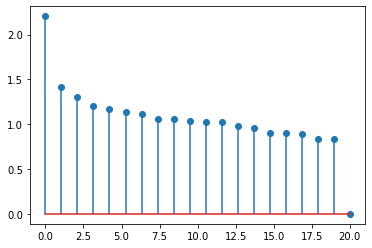

In [10]:
x = np.linspace(0, 20, 20)
y = pca.eigenvalues

plt.stem(x, y, use_line_collection=True)
plt.show()

The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. PCA is about finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

Here we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the “length” or “magnitude” of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others, then the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the “less informative” eigenpairs is reasonable.

### 1. principal component (PC1)
The eigenvalue with the largest absolute value will indicate that the data have the largest variance along its eigenvector, the direction along which there is greatest variation
### 2. principal component (PC2)
The direction with maximum variation left in data,  orthogonal to the first PC.
In general, only few directions manage to capture most of the variability in the data.

In [11]:
y_human = np.ones(np.shape(ran_seq['human'])[0])
y_machine = np.full(np.shape(ran_seq['machine'])[0], -1)

X = np.vstack((ran_seq['human'],ran_seq['machine']))
y = np.hstack((y_human,y_machine))

w_opt = np.linalg.inv(X.T @ X) @ X.T @ y
print("Optimal weights are: {}".format(w_opt))
y_predict = np.sign(X @ w_opt)
error = np.mean(y != y_predict)
print("Computed Test Error rate from hard decision: {}".format(error))

Optimal weights are: [-0.03190931  0.01726426 -0.01364337 -0.03425781  0.01059267 -0.00102541
  0.01311005 -0.0147587  -0.03193807  0.01223412 -0.02233386 -0.00145941
  0.0029169  -0.01706871 -0.00667414 -0.02850383 -0.00124367 -0.01104853
 -0.00275187  0.00782255]
Computed Test Error rate from hard decision: 0.4688235294117647


No handles with labels found to put in legend.


Text(0, 0.5, &#39;Second Principal Component&#39;)

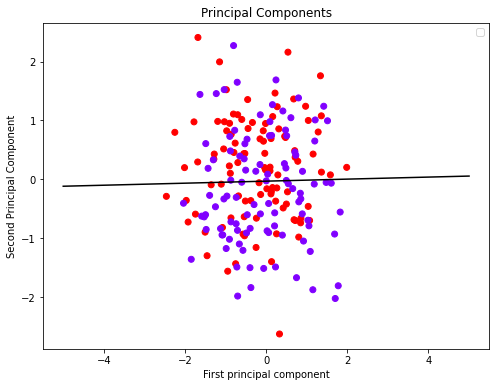

In [12]:
X = np.vstack((ran_seq['human'][:100], ran_seq['machine'][:100]))
y = np.hstack((y_human[:100],y_machine[:100]))

pca = PCA(n_components=2, whiten=True)
pca.fit(scaled_data)
X_prime = pca.transform(X)

plt.figure(figsize=(8, 6))
plt.title("Principal Components")
plt.scatter(X_prime[:, 0], X_prime[:, 1], c=y, cmap='rainbow')

t = np.linspace(-5,5,10000)
plt.plot(t, w_opt[1]*t+w_opt[0], color = 'black')
plt.legend()
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [13]:
X = np.vstack((ran_seq['human'],ran_seq['machine']))
y = np.hstack((y_human,y_machine))
log_clf = SGDClassifier(tol=1e-3, random_state=0, loss="log", eta0=1, learning_rate="constant", penalty=None)
log_clf.fit(X, y)
print("Logistic Regssion based classifier test error rate",(1-log_clf.score(X,y)))
print("Weights Computed :",log_clf.coef_)

Logistic Regssion based classifier test error rate 0.4998039215686274
Weights Computed : [[-1.06687052e+00  4.45732485e-01  7.65748044e-01 -3.67430080e+00
  -1.95209497e+00  6.41238048e-01 -1.86227335e-03  2.94365285e+00
  -1.77086607e+00 -3.12722766e+00  1.99098286e-01 -1.33915368e+00
   2.73727730e+00 -1.85134291e+00 -3.09761485e-01  2.15354747e+00
  -2.08465919e+00  1.43466432e+00 -2.24706188e+00 -1.95200402e+00]]
